In [1]:

import torch
import numpy as np
from autoencoder import ConvDecoder, ConvEncoder
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import time
import random
%matplotlib inline

In [2]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    #print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [3]:
image_paths=[]
with open("geological_map.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

29998


In [4]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    # image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()

    #print(image_embedding.shape)

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    #print(flattened_embedding.shape)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)
    start_time=time.time()
    _, indices = knn.kneighbors(flattened_embedding)
    end_time=time.time()
    time_taken=end_time-start_time
    #print("Time taken: ",end_time-start_time)
    indices_list = indices.tolist()
    
    #print(indices_list)
    return indices_list,time_taken


In [5]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    print("total indices: ", len(indices))
    print(indices_list)
    for index in indices:
        # img_name = str(index - 1) + ".jpg"
        # print(img_name)
        img_path = image_paths[index]
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

In [6]:
TEST_IMAGE_PATH = "geological_similarity/schist/ZZ5Z5.jpg"
NUM_IMAGES = 50
ENCODER_MODEL_PATH = "geological_encoding.pt"
EMBEDDING_PATH = "geological_embed.npy"

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = ConvEncoder()

# Load the state dict of encoder
encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load(EMBEDDING_PATH)
# test_img = Image.open(TEST_IMAGE_PATH).convert("RGB")
# plt.imshow(test_img)
# plt.show()
# indices_list = compute_similar_images(TEST_IMAGE_PATH, NUM_IMAGES, embedding, device)
# plot_similar_images(indices_list)

In [9]:
embedding.shape

(29998, 576)

In [13]:
#trying out Principal Component Analysis
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
results=pca.fit_transform(embedding)
print(results)


[[-2.806795   -3.0074627 ]
 [-7.153034    0.21609813]
 [-3.515173   -2.1083124 ]
 ...
 [ 0.53168243  0.8761272 ]
 [ 1.420965    3.0928507 ]
 [ 3.397298   -1.1068012 ]]


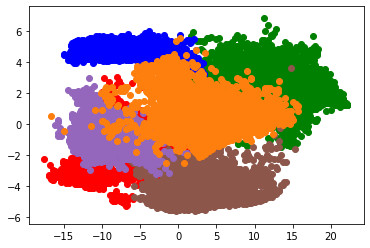

In [26]:
x= [i[0] for i in results]
y=[i[1] for i in results]
x_andesite=x[:5000]
y_andesite=y[:5000]
x_gneiss=x[5000:10000]
y_gneiss=y[5000:10000]
x_marble=x[10000:14998]
y_marble=y[10000:14998]
x_quartzite=x[14998:19998]
y_quartzite=y[14998:19998]
x_rhyolite=x[19998:24998]
y_rhyolite=y[19998:24998]
x_schist=x[24998:29998]
y_schist=y[24998:29998]
plt.scatter(x_andesite,y_andesite,c="r")
plt.scatter(x_gneiss,y_gneiss,c="g")
plt.scatter(x_marble,y_marble,c="b")
plt.scatter(x_quartzite,y_quartzite,c="#8c564b")
plt.scatter(x_rhyolite,y_rhyolite,c="#9467bd")
plt.scatter(x_schist,y_schist,c="#ff7f0e")
plt.show()

In [296]:
def write_to_file(test_img_path,indices_list,file_name):
    indices = indices_list[0]
    results=[]
    for index in indices:
        img_path = image_paths[index]
        results.append(img_path)
    #results_string=' '.join(i for i in results)
    #print(results)
    with open(file_name, 'r', encoding='utf-8') as f:
        current_dir=json.load(f)
    current_dir[test_img_path]=results
    with open(file_name, "w") as outfile:
        json.dump(current_dir, outfile)


In [297]:
testing_times=[]

In [298]:
def test_method(test_img_path,file_name):
    test_img = Image.open(test_img_path).convert("RGB")
    # plt.imshow(test_img)
    # plt.show()
    indices_list,time_taken = compute_similar_images(test_img_path, NUM_IMAGES, embedding, device)
    #write_to_file(test_img_path,indices_list,file_name)
    #plot_similar_images(indices_list)
    testing_times.append(time_taken)
    return time_taken

In [299]:
testing_images=[]
for i in range(0,100):
    random_index=random.randint(0, len(image_paths)-1)
    testing_images.append(image_paths[random_index])

for i in range(len(testing_images)):
    time_taken=test_method(testing_images[i],"jaccard_knn_results.json")
    print(time_taken)

0.10400271415710449
0.14098906517028809
0.08999848365783691
0.08243918418884277
0.07900214195251465
0.06600046157836914
0.06700372695922852
0.07898306846618652
0.06894922256469727
0.07100057601928711
0.0670006275177002
0.07100176811218262
0.07399821281433105
0.07600092887878418
0.06800007820129395
0.07699918746948242
0.06600117683410645
0.06600046157836914
0.07500004768371582
0.07100296020507812
0.06400203704833984
0.07999992370605469
0.06699919700622559
0.09123921394348145
0.0670006275177002
0.08100056648254395
0.07100105285644531
0.08000636100769043
0.06699919700622559
0.0780029296875
0.06499624252319336
0.07599878311157227
0.06800007820129395
0.07400155067443848
0.07035684585571289
0.07300186157226562
0.07300019264221191
0.0650014877319336
0.07599973678588867
0.07000017166137695
0.07399797439575195
0.0670003890991211
0.08300232887268066
0.06800031661987305
0.06594133377075195
0.07094717025756836
0.06599950790405273
0.06500244140625
0.0690004825592041
0.06800198554992676
0.0649991035

In [286]:
# dic={"Hello":"Wow"}
# with open("cosine_knn_results.json", "w") as outfile:
#     json.dump(dic, outfile)

In [301]:
avg_test_time=sum(testing_times)/len(testing_times)
print(avg_test_time)

0.07410224199295044


In [173]:
with open("jaccard_knn_results.json", 'r', encoding='utf-8') as f:
    content=json.load(f)
print(len(content.keys()))

100


In [174]:
textfile = open("timing_results/jaccard_knn_timings.txt", "w")
for i in range(len(testing_times)):

    textfile.write(str(testing_times[i])+"\n")

textfile.close()

### Next cell is to read the timings files

In [9]:
stored_times=[]
with open("timing_results/cosine_knn_timings.txt","r") as f:
    content=f.read()
stored_times=content.split('\n')
print(len(stored_times))

100


In [10]:
stored_times= [float(i) for i in stored_times]
sum(stored_times)/len(stored_times)

0.0992603874206543